In [3]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix

    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
data_set_path = 'NSL-KDD/KDDTrain+.txt'
test_data_set_path = 'NSL-KDD/KDDTest+.txt'
headers=['duration', 'protocol_type','service','flag', 'src_bytes', 'dst_bytes','land', 'wrong_fragment', 'urgent', 'hot',
         'num_failed_logins', 'logged_in','num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
         'num_shells', 'num_access_files', 'num_outbound_cmds',  'is_host_login', 'is_guest_login', 'count', 'srv_count',
         'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate','srv_diff_host_rate',
         'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
         'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate','dst_host_srv_rerror_rate',
         'type', 'difficulty']

In [13]:
def prepare_test_data(attack1, attack2):
    test_dataset = pd.read_csv(test_data_set_path, names=headers, header=0)
    test_dt = test_dataset.loc[(test_dataset['type'] != attack1) & (test_dataset['type'] != attack2)]
    test_dt['type'] = test_dt['type'].str.replace(r"^(.(?<!normal))*?$", "attack")
    return test_dt

In [14]:
# This function returns a "train_data" df based on the two attacks selected
def prepare_train_subset(normal_data, full_dataset, attack1, attack2):
    train_subset = normal_data.copy()
    attack1_data = full_dataset.loc[full_dataset['type'] == attack1]
    attack2_data = full_dataset.loc[full_dataset['type'] == attack2]
    train_subset = train_subset.append(attack1_data)
    train_subset = train_subset.append(attack2_data)
    train_subset = train_subset.replace(attack1, 'attack')
    train_subset = train_subset.replace(attack2, 'attack')
    print("Training subset with " + attack1 + " and " + attack2 + " with shape ")
    print(train_subset.shape)
    return shuffle(train_subset)

In [15]:
def get_unique_categories(train_data, test_data):
    temp_service = train_data.service.unique().tolist()
    temp_service.extend(test_data.service.unique().tolist())
    service_categories = set(temp_service)
    services = [ x for x in iter(service_categories) ]

    protocol_type = train_data.protocol_type.unique().tolist()
    protocol_type.extend(test_data.protocol_type.unique().tolist())
    protocol = set(protocol_type)
    protocols = [x for x in iter(protocol)]


    flag = train_data.flag.unique().tolist()
    flag.extend(test_data.flag.unique().tolist())
    flag_val = set(flag)
    flag_values = [x for x in iter(flag_val)]


    categories = [protocols, services, flag_values]
    return categories

In [16]:
def encode_values(X, test_X, Y, test_Y, categories):
    # First label encode 'normal' and 'attack' labels
    labelencoder_Y = LabelEncoder()
    processed_Y = labelencoder_Y.fit_transform(Y)
    processed_test_Y = labelencoder_Y.transform(test_Y)

    preprocess = OneHotEncoder(categories=categories)
    processed_X = preprocess.fit_transform(X[:,1:4]).toarray()
    processed_X = pd.concat([pd.DataFrame(X[:,0]), pd.DataFrame(processed_X), pd.DataFrame(X[:,5:])], axis=1, ignore_index=True).values
    processed_test_X = preprocess.transform(test_X[:, 1:4]).toarray()
    processed_test_X = pd.concat([pd.DataFrame(test_X[:,0]), pd.DataFrame(processed_test_X), pd.DataFrame(test_X[:,5:])], axis=1, ignore_index=True).values

    print("Shape of train data after encoding is {0} and test data is {1}".format(processed_X.shape, processed_test_X.shape))
    return processed_X, processed_test_X, processed_Y, processed_test_Y

In [17]:
def train_nn(train_data, test_data):
    categories = get_unique_categories(train_data, test_data)
    X = train_data.iloc[:, 0:-2].values
    Y = train_data.iloc[:, -2].values
    test_X = test_data.iloc[:, 0:-2].values
    test_Y = test_data.iloc[:, -2].values
    print("Training data has shape of {0} and test data has shape of {1}".format(X.shape, test_X.shape))
    X_Train, X_Test, Y_Train, Y_Test = encode_values(X, test_X, Y, test_Y, categories)
    sc = StandardScaler()
    X_Train = sc.fit_transform(X_Train)
    X_Test = sc.transform(X_Test)
    print("Shapes of train and test data are {0}, {1}".format(X_Train.shape, X_Test.shape))
    x_train,x_valid,y_train,y_valid = train_test_split(X_Train, Y_Train, test_size = 0.15, random_state = 42)
    classifier = Sequential()
    classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu', input_dim = x_train.shape[1]))
    classifier.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
    classifierHistory = classifier.fit(x_train, y_train, batch_size = 100, validation_data=(x_valid, y_valid), epochs = 100)
    y_pred = classifier.predict(X_Test)
    y_pred = (y_pred > 0.9)
    return accuracy_score(Y_Test, y_pred), classifierHistory, Y_Test, y_pred

In [10]:
attack_types = ['neptune','warezclient','ipsweep','portsweep','teardrop','nmap', 'satan', 'smurf', 'pod', 'back', 'guess_passwd', 'ftp_write', 'multihop', 'rootkit', 'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land', 'loadmodule','spy','perl']
full_dataset = pd.read_csv(data_set_path, names=headers, header=0)
val = pd.value_counts(full_dataset['type'])
Labels = val.index.values
Values = val.tolist()
print(Values)


[67342, 41214, 3633, 3599, 2931, 2646, 1493, 956, 892, 890, 201, 53, 30, 20, 18, 11, 10, 9, 8, 7, 4, 3, 2]


In [24]:
# First grab the normal data out
normal_data = full_dataset.loc[full_dataset['type'] == 'normal']
#A1 - warezmaster, portsweep
#A2 - nmap,buffer_overflow
#A3 - teardrop, multihop
#A4 - Neptune, Satan
#A5 - 
#attack1 = 'warezmaster'
#attack2 = 'portsweep'
attack1 = 'nmap'
attack2 = 'buffer_overflow'
test_dataset = prepare_test_data(attack1, attack2)
train_df = prepare_train_subset(normal_data, full_dataset, attack1, attack2)
accuracy,classifierHistory, y_test, y_pred = train_nn(train_df, test_dataset)

/Users/tchinmai/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Training subset with nmap and buffer_overflow with shape 
(68865, 43)
Training data has shape of (68865, 41) and test data has shape of (22450, 41)
Shape of train data after encoding is (68865, 117) and test data is (22450, 117)


/Users/tchinmai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tchinmai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/tchinmai/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Shapes of train and test data are (68865, 117), (22450, 117)
Train on 58535 samples, validate on 10330 samples
Epoch 1/100
58535/58535 [==============================] - 2s 26us/step - loss: 0.1231 - acc: 0.9778 - val_loss: 0.0232 - val_acc: 0.9917
Epoch 2/100
58535/58535 [==============================] - 1s 18us/step - loss: 0.0156 - acc: 0.9966 - val_loss: 0.0117 - val_acc: 0.9970
Epoch 3/100
58535/58535 [==============================] - 1s 18us/step - loss: 0.0096 - acc: 0.9975 - val_loss: 0.0095 - val_acc: 0.9970
Epoch 4/100
58535/58535 [==============================] - 1s 18us/step - loss: 0.0078 - acc: 0.9976 - val_loss: 0.0085 - val_acc: 0.9971
Epoch 5/100
58535/58535 [==============================] - 1s 18us/step - loss: 0.0071 - acc: 0.9979 - val_loss: 0.0076 - val_acc: 0.9978
Epoch 6/100
58535/58535 [==============================] - 1s 18us/step - loss: 0.0066 - acc: 0.9981 - val_loss: 0.0076 - val_acc: 0.9979
Epoch 7/100
58535/58535 [==============================] - 1s

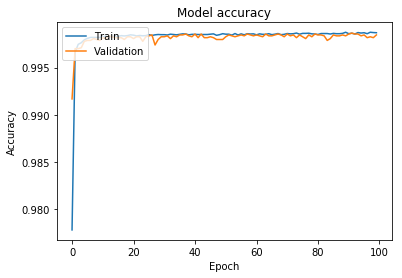

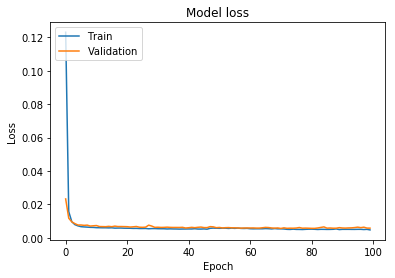

In [25]:
# Plot training & validation accuracy values
plt.plot(classifierHistory.history['acc'])
plt.plot(classifierHistory.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

    # Plot training & validation loss values
plt.plot(classifierHistory.history['loss'])
plt.plot(classifierHistory.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
    

In [26]:
print(accuracy)

0.5043207126948775


In [27]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 1635 11104]
 [   24  9687]]
